In [4]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [5]:
import torch_geometric; print(torch_geometric.__version__)

2.0.4


In [7]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [8]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'
root_dataset = 'common_dataset'

In [9]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [10]:
train = torch.load(f'{root_dataset}/train_data.pt')
val = torch.load(f'{root_dataset}/val_set.pt')
test = torch.load(f'{root_dataset}/test_set.pt')

In [11]:
### PROVA
print(train)
print(val.shape)
print(val)
print(test.shape)

HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 181644] },
  (artwork, createdby, artist)={ edge_index=[2, 52188] },
  (artwork, elicit, emotion)={ edge_index=[2, 52188] },
  (artwork, hasgenre, genre)=

In [12]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.index = data_labels.artwork
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,1,4,4
28493,28493,3,9,5
28421,28421,3,3,8
28393,28393,3,9,8
28380,28380,3,9,7
...,...,...,...,...
71300,71300,10,6,8
68290,68290,23,6,8
68567,68567,23,6,8


In [13]:
# PROVA
data_prova=data_labels.loc[data_labels['artwork'].isin(val)]

In [14]:
# PROVA
data_prova

,artwork,style,genre,emotion
artwork,,,,


In [15]:
train_dataset = TrainingDataSet(graph = train, data_labels = data_labels)

In [16]:
val_dataset = TestDataSet(graph = train, x_test = val, data_labels = data_labels)

tensor([40118, 74027,  7776,  ..., 57596, 68515,  3083])
         artwork  style  genre  emotion
artwork                                
81418      81418      1      4        4
28493      28493      3      9        5
28421      28421      3      3        8
28393      28393      3      9        8
28380      28380      3      9        7
...          ...    ...    ...      ...
71300      71300     10      6        8
68290      68290     23      6        8
68567      68567     23      6        8
69055      69055     10      6        8
65386      65386     23      6        8

[65236 rows x 4 columns]


In [17]:
test_dataset = TestDataSet(graph = train, x_test = test, data_labels = data_labels)

tensor([58798, 60364,  6774,  ..., 15295, 41140, 20064])
         artwork  style  genre  emotion
artwork                                
81418      81418      1      4        4
28493      28493      3      9        5
28421      28421      3      3        8
28393      28393      3      9        8
28380      28380      3      9        7
...          ...    ...    ...      ...
71300      71300     10      6        8
68290      68290     23      6        8
68567      68567     23      6        8
69055      69055     10      6        8
65386      65386     23      6        8

[65236 rows x 4 columns]


In [18]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

52188
6523
6525


In [19]:
# EDA analysis 
tr_df=train_dataset.data

In [20]:
tr_df

,artwork,style,genre,emotion
artwork,,,,
96,96,13,9,5
99,99,13,12,2
102,102,13,9,1
119,119,13,12,4
124,124,13,15,1
...,...,...,...,...
84724,84724,14,9,4
84725,84725,14,9,2
84726,84726,14,9,2


In [21]:
v_df=val_dataset.data

In [22]:
te_df=test_dataset.data

In [23]:
s_labels='style_entidx2name.csv'
g_labels='genre_entidx2name.csv'
e_labels='emotion_entidx2name.csv'

In [24]:
style_labels = pd.read_csv('artgraph2bestemotions/mapping/'+ s_labels, names=['index', 'style'])
genre_labels = pd.read_csv('artgraph2bestemotions/mapping/'+ g_labels,names=['index', 'genre'])
emotion_labels = pd.read_csv('artgraph2bestemotions/mapping/'+ e_labels,names=['index', 'emotion'])

In [25]:
style_labels

,index,style
0,0,art deco
1,1,art nouveau (modern)
2,2,baroque
3,3,expressionism
4,4,contemporary realism
5,5,neo-expressionism
6,6,magic realism
7,7,cubism
8,8,northern renaissance
9,9,early renaissance


In [26]:
genre_labels

,index,genre
0,0,nude painting (nu)
1,1,marina
2,2,animal painting
3,3,self-portrait
4,4,genre painting
5,5,symbolic painting
6,6,abstract
7,7,figurative
8,8,landscape
9,9,portrait


In [27]:
emotion_labels

,index,emotion
0,0,anger
1,1,awe
2,2,contentment
3,3,excitement
4,4,sadness
5,5,amusement
6,6,disgust
7,7,fear
8,8,something else


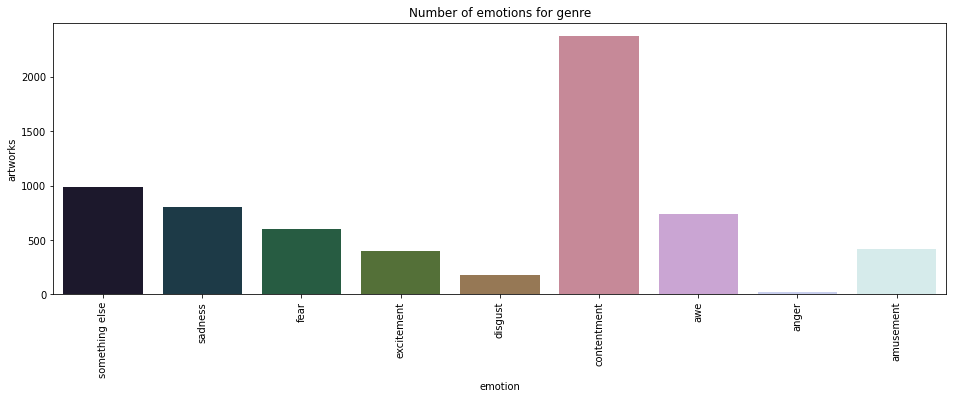

In [28]:
#EDA training set
import seaborn as sns
temp = te_df.groupby(["emotion"])["artwork"].count()
label_df=emotion_labels
df = pd.DataFrame({"emotion": label_df['emotion'][label_df['index'].isin(temp.index)], "artworks": temp.values})
df = df.sort_values(["emotion"], ascending=False)
plt.figure(figsize=(16, 5))
plt.title("Number of emotions for genre")
s = sns.barplot(x="emotion", y="artworks", data=df, palette="cubehelix")
s.set_xticklabels(s.get_xticklabels(), rotation=90)
locs, labels = plt.xticks()
plt.show()

In [29]:
tr_df.corr()

,artwork,style,genre,emotion
artwork,1.000000,-0.100248,-0.113473,0.047041
style,-0.100248,1.000000,-0.037342,-0.117970
genre,-0.113473,-0.037342,1.000000,-0.036604
emotion,0.047041,-0.117970,-0.036604,1.000000


In [30]:
v_df.corr()

,artwork,style,genre,emotion
artwork,1.000000,-0.092575,-0.104792,0.032064
style,-0.092575,1.000000,-0.042802,-0.115663
genre,-0.104792,-0.042802,1.000000,-0.031853
emotion,0.032064,-0.115663,-0.031853,1.000000


In [31]:
te_df.corr()

,artwork,style,genre,emotion
artwork,1.000000,-0.078944,-0.110456,0.052289
style,-0.078944,1.000000,-0.048676,-0.145043
genre,-0.110456,-0.048676,1.000000,-0.055528
emotion,0.052289,-0.145043,-0.055528,1.000000


In [29]:
print(train_dataset.__getitem__(5))
print(val_dataset.__getitem__(5))
print(test_dataset.__getitem__(5))

(tensor([ 13.0308, -12.0007, -26.9583,  14.9336,  16.1660,  -2.9494,   5.7810,
         -0.7698,   3.8849,  -9.8246,  -9.3594,   0.1326,   0.3213,   0.7171,
         -3.0149,   1.0500,   9.7578, -11.5302,   3.2309,  -8.2401,  -8.0104,
          2.3737,  -5.8326,   4.5817,   2.2560,  -0.4150,  -7.2257,   6.3593,
          3.1297,   9.0368,  -0.1089,   1.6999,   0.0643,   4.8557,   1.7369,
          2.8820,  -0.4930,   3.9492,  -2.1077,   5.3206,   6.2596,   6.9810,
         -4.6957,   4.0200,  -1.7120,   4.1701,   0.1111,  -1.6024,  -3.4216,
         -5.4410,   1.0416,  -0.4479,  -0.6380,  -3.9669,  -5.8663,   0.6181,
         -1.7065,  -1.6279,  -5.6199,  -0.1076,   3.0115,   0.4466,  -1.6512,
         -0.3201,   0.3017,  -0.2759,  -4.4069,   4.1214,  -3.2938,  -3.0045,
         -0.0606,   3.8806,  -4.4857,  -0.4037,  -0.2405,   2.7040,   7.4704,
         -0.9448,   1.8401,  -1.4386,   2.6653,   2.7039,  -2.4744,   1.3917,
          3.9999,  -2.5678,   1.3852,  -3.8944,  -2.9268,   0.6

Test per vedere se va bene il modello pre-trained

In [32]:
device = torch.device('cuda:0') #cuda:0
genre_model = torch.load('genre.pt').to(device)
genre_model

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

In [31]:
from tqdm import tqdm
device = torch.device('cuda:0') #cuda:0
train = train.to(device)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, drop_last = False)
with torch.no_grad():
    running_corrects = 0 
    for images, (style_labels, genre_labels, emotion_labels) in tqdm(test_loader):
        images = images.to(device, non_blocking = True)
        genre_labels = genre_labels.to(device, non_blocking = True)
        genre_pred = genre_model(train.x_dict, train.edge_index_dict, images)
        running_corrects += torch.sum(torch.max(genre_pred, 1)[1] == genre_labels)
    print(f'Acc: {running_corrects/len(test_loader.dataset)}')

100%|██████████| 51/51 [00:05<00:00,  9.30it/s]

Acc: 0.8140996694564819


## INSTANTIATING MODEL

In [33]:
device = torch.device('cuda:0') #cuda:0
style_encoder = torch.load('best_model_style_single_task.pt').encoder
genre_encoder = torch.load('best_model_genre_single_task.pt').encoder
emotion_encoder = torch.load('best_model_emotion_single_task.pt').encoder
model = NewMultiTaskClassificationModel(data = data, hidden_channels=None, head_num_layers=5,
                                        encoders = (style_encoder, genre_encoder, emotion_encoder)).to(device)

In [34]:
model

NewMultiTaskClassificationModel(
  (encoder_style): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_genre): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_emotion): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=7680, out_features=3840, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=3840, out_features=1920, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1920, out_features=960, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=960, out_features=480, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (

In [35]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder_style(train.x_dict, train.edge_index_dict)
    model.encoder_genre(train.x_dict, train.edge_index_dict)
    model.encoder_emotion(train.x_dict, train.edge_index_dict)

In [36]:
embedding_style=model.encoder_style(train.x_dict , train.edge_index_dict)

In [37]:
embedding_style

tensor([-1.0000,  0.9435,  0.9999,  ..., -0.9994,  1.0000, -1.0000],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [38]:
embedding_genre=model.encoder_genre(train.x_dict , train.edge_index_dict)

In [39]:
embedding_genre.shape

torch.Size([2304])

In [40]:
embedding_emotion=model.encoder_emotion(train.x_dict , train.edge_index_dict)

In [41]:
embedding_emotion.shape

torch.Size([1152])

In [54]:
!pip install numpy

In [73]:
# Visualize embeddings

import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA

#df = px.data.iris()
#X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
embedding = np.array(embedding_emotion.tolist()).reshape(1152,1).T #reshape(4096,1).
#print(embedding.shape)
embedding_arrays = np.split(embedding[0], 128)
#print(len(embedding_arrays))
embedding_matrix=np.asmatrix(embedding_arrays).T
print(embedding_matrix.shape)
pca = PCA(n_components=2)
components = pca.fit_transform(embedding_matrix)

labelz=emotion_labels['emotion'].tolist()
print(labelz)
fig = px.scatter(components, x=0, y=1, color=labelz)
fig.show()


(9, 128)
['anger', 'awe', 'contentment', 'excitement', 'sadness', 'amusement', 'disgust', 'fear', 'something else']


C:\Users\aless\anaconda3\envs\tesi\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [70]:
visualize(embedding_style,color=train.style)

AttributeError: 'HeteroData' has no attribute 'style'

In [21]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_new_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:55<00:00,  3.54it/s]


train Loss: 1.7875 Style Acc: 0.3180
            Genre Acc: 0.5483
            Emotion Acc: 0.3797


100%|██████████| 51/51 [00:04<00:00, 10.75it/s]


val Loss: 1.4901 Style Acc: 0.4220
            Genre Acc: 0.6541
            Emotion Acc: 0.4110
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.59it/s]


train Loss: 1.4476 Style Acc: 0.4422
            Genre Acc: 0.6675
            Emotion Acc: 0.4111


100%|██████████| 51/51 [00:04<00:00, 10.52it/s]


val Loss: 1.3812 Style Acc: 0.4831
            Genre Acc: 0.6877
            Emotion Acc: 0.4188
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.3752 Style Acc: 0.4813
            Genre Acc: 0.6806
            Emotion Acc: 0.4188


100%|██████████| 51/51 [00:04<00:00, 10.27it/s]


val Loss: 1.3347 Style Acc: 0.4971
            Genre Acc: 0.6955
            Emotion Acc: 0.4331
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.3333 Style Acc: 0.5058
            Genre Acc: 0.6957
            Emotion Acc: 0.4256


100%|██████████| 51/51 [00:04<00:00, 10.49it/s]


val Loss: 1.3137 Style Acc: 0.5202
            Genre Acc: 0.6913
            Emotion Acc: 0.4360
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.3001 Style Acc: 0.5249
            Genre Acc: 0.7033
            Emotion Acc: 0.4297


100%|██████████| 51/51 [00:04<00:00, 10.88it/s]


val Loss: 1.2836 Style Acc: 0.5268
            Genre Acc: 0.7094
            Emotion Acc: 0.4354
Validation loss decreased. Saving model...
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 1.2750 Style Acc: 0.5386
            Genre Acc: 0.7065
            Emotion Acc: 0.4329


100%|██████████| 51/51 [00:04<00:00, 10.88it/s]


val Loss: 1.2918 Style Acc: 0.5406
            Genre Acc: 0.6892
            Emotion Acc: 0.4343
EarlyStopping counter: 1 out of 5
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.59it/s]


train Loss: 1.2551 Style Acc: 0.5480
            Genre Acc: 0.7131
            Emotion Acc: 0.4355


100%|██████████| 51/51 [00:04<00:00, 10.36it/s]


val Loss: 1.2692 Style Acc: 0.5479
            Genre Acc: 0.7080
            Emotion Acc: 0.4347
Validation loss decreased. Saving model...
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.2355 Style Acc: 0.5593
            Genre Acc: 0.7180
            Emotion Acc: 0.4392


100%|██████████| 51/51 [00:04<00:00, 10.83it/s]


val Loss: 1.2659 Style Acc: 0.5389
            Genre Acc: 0.7134
            Emotion Acc: 0.4354
Validation loss decreased. Saving model...
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.2195 Style Acc: 0.5671
            Genre Acc: 0.7213
            Emotion Acc: 0.4398


100%|██████████| 51/51 [00:04<00:00, 10.46it/s]


val Loss: 1.2489 Style Acc: 0.5530
            Genre Acc: 0.7184
            Emotion Acc: 0.4324
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.2048 Style Acc: 0.5766
            Genre Acc: 0.7268
            Emotion Acc: 0.4441


100%|██████████| 51/51 [00:04<00:00, 10.87it/s]


val Loss: 1.2502 Style Acc: 0.5578
            Genre Acc: 0.7120
            Emotion Acc: 0.4301
EarlyStopping counter: 1 out of 5
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 1.1908 Style Acc: 0.5864
            Genre Acc: 0.7288
            Emotion Acc: 0.4440


100%|██████████| 51/51 [00:04<00:00, 10.82it/s]


val Loss: 1.2218 Style Acc: 0.5761
            Genre Acc: 0.7180
            Emotion Acc: 0.4357
Validation loss decreased. Saving model...
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.1784 Style Acc: 0.5889
            Genre Acc: 0.7345
            Emotion Acc: 0.4442


100%|██████████| 51/51 [00:04<00:00, 10.28it/s]


val Loss: 1.2191 Style Acc: 0.5731
            Genre Acc: 0.7232
            Emotion Acc: 0.4363
Validation loss decreased. Saving model...
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.1640 Style Acc: 0.5978
            Genre Acc: 0.7379
            Emotion Acc: 0.4480


100%|██████████| 51/51 [00:04<00:00, 10.87it/s]


val Loss: 1.2319 Style Acc: 0.5806
            Genre Acc: 0.7232
            Emotion Acc: 0.4360
EarlyStopping counter: 1 out of 5
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.1512 Style Acc: 0.6040
            Genre Acc: 0.7396
            Emotion Acc: 0.4500


100%|██████████| 51/51 [00:04<00:00, 10.43it/s]


val Loss: 1.2007 Style Acc: 0.5813
            Genre Acc: 0.7338
            Emotion Acc: 0.4479
Validation loss decreased. Saving model...
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.59it/s]


train Loss: 1.1363 Style Acc: 0.6125
            Genre Acc: 0.7449
            Emotion Acc: 0.4531


100%|██████████| 51/51 [00:04<00:00, 10.78it/s]


val Loss: 1.2003 Style Acc: 0.5884
            Genre Acc: 0.7315
            Emotion Acc: 0.4390
EarlyStopping counter: 1 out of 5
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.1235 Style Acc: 0.6187
            Genre Acc: 0.7489
            Emotion Acc: 0.4534


100%|██████████| 51/51 [00:04<00:00, 10.60it/s]


val Loss: 1.2046 Style Acc: 0.5844
            Genre Acc: 0.7296
            Emotion Acc: 0.4305
EarlyStopping counter: 2 out of 5
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.59it/s]


train Loss: 1.1120 Style Acc: 0.6241
            Genre Acc: 0.7519
            Emotion Acc: 0.4552


100%|██████████| 51/51 [00:04<00:00, 10.56it/s]


val Loss: 1.1908 Style Acc: 0.5960
            Genre Acc: 0.7327
            Emotion Acc: 0.4355
Validation loss decreased. Saving model...
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.0967 Style Acc: 0.6332
            Genre Acc: 0.7557
            Emotion Acc: 0.4574


100%|██████████| 51/51 [00:04<00:00, 10.81it/s]


val Loss: 1.1748 Style Acc: 0.6026
            Genre Acc: 0.7411
            Emotion Acc: 0.4396
Validation loss decreased. Saving model...
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 1.0866 Style Acc: 0.6388
            Genre Acc: 0.7592
            Emotion Acc: 0.4587


100%|██████████| 51/51 [00:04<00:00, 10.58it/s]


val Loss: 1.1778 Style Acc: 0.6031
            Genre Acc: 0.7284
            Emotion Acc: 0.4438
EarlyStopping counter: 1 out of 5
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 1.0722 Style Acc: 0.6457
            Genre Acc: 0.7634
            Emotion Acc: 0.4614


100%|██████████| 51/51 [00:04<00:00, 10.78it/s]


val Loss: 1.1735 Style Acc: 0.6025
            Genre Acc: 0.7376
            Emotion Acc: 0.4407
Validation loss decreased. Saving model...
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.0593 Style Acc: 0.6527
            Genre Acc: 0.7681
            Emotion Acc: 0.4624


100%|██████████| 51/51 [00:04<00:00, 10.49it/s]


val Loss: 1.1774 Style Acc: 0.5982
            Genre Acc: 0.7322
            Emotion Acc: 0.4383
EarlyStopping counter: 1 out of 5
Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 1.0459 Style Acc: 0.6591
            Genre Acc: 0.7736
            Emotion Acc: 0.4644


100%|██████████| 51/51 [00:04<00:00, 10.44it/s]


val Loss: 1.1897 Style Acc: 0.6008
            Genre Acc: 0.7290
            Emotion Acc: 0.4370
Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 1.0043 Style Acc: 0.6785
            Genre Acc: 0.7860
            Emotion Acc: 0.4708


100%|██████████| 51/51 [00:04<00:00, 10.66it/s]


val Loss: 1.1511 Style Acc: 0.6161
            Genre Acc: 0.7482
            Emotion Acc: 0.4381
Validation loss decreased. Saving model...
Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 0.9905 Style Acc: 0.6859
            Genre Acc: 0.7890
            Emotion Acc: 0.4717


100%|██████████| 51/51 [00:04<00:00, 10.71it/s]


val Loss: 1.1461 Style Acc: 0.6218
            Genre Acc: 0.7439
            Emotion Acc: 0.4395
Validation loss decreased. Saving model...
Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 0.9812 Style Acc: 0.6938
            Genre Acc: 0.7897
            Emotion Acc: 0.4744


100%|██████████| 51/51 [00:04<00:00, 10.86it/s]


val Loss: 1.1477 Style Acc: 0.6178
            Genre Acc: 0.7462
            Emotion Acc: 0.4429
EarlyStopping counter: 1 out of 5
Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 0.9705 Style Acc: 0.6977
            Genre Acc: 0.7951
            Emotion Acc: 0.4758


100%|██████████| 51/51 [00:04<00:00, 10.77it/s]


val Loss: 1.1444 Style Acc: 0.6244
            Genre Acc: 0.7430
            Emotion Acc: 0.4393
Validation loss decreased. Saving model...
Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 0.9605 Style Acc: 0.7021
            Genre Acc: 0.7988
            Emotion Acc: 0.4765


100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


val Loss: 1.1458 Style Acc: 0.6224
            Genre Acc: 0.7465
            Emotion Acc: 0.4389
EarlyStopping counter: 1 out of 5
Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:52<00:00,  3.61it/s]


train Loss: 0.9496 Style Acc: 0.7087
            Genre Acc: 0.8034
            Emotion Acc: 0.4779


100%|██████████| 51/51 [00:04<00:00, 10.79it/s]


val Loss: 1.1452 Style Acc: 0.6236
            Genre Acc: 0.7426
            Emotion Acc: 0.4455
Epoch 00028: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:52<00:00,  3.61it/s]


train Loss: 0.9262 Style Acc: 0.7197
            Genre Acc: 0.8103
            Emotion Acc: 0.4830


100%|██████████| 51/51 [00:04<00:00, 10.84it/s]


val Loss: 1.1382 Style Acc: 0.6297
            Genre Acc: 0.7439
            Emotion Acc: 0.4398
Validation loss decreased. Saving model...
Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.61it/s]


train Loss: 0.9172 Style Acc: 0.7260
            Genre Acc: 0.8122
            Emotion Acc: 0.4854


100%|██████████| 51/51 [00:04<00:00, 10.70it/s]


val Loss: 1.1417 Style Acc: 0.6307
            Genre Acc: 0.7463
            Emotion Acc: 0.4390
EarlyStopping counter: 1 out of 5
Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:52<00:00,  3.61it/s]


train Loss: 0.9113 Style Acc: 0.7281
            Genre Acc: 0.8134
            Emotion Acc: 0.4831


100%|██████████| 51/51 [00:04<00:00, 10.74it/s]


val Loss: 1.1441 Style Acc: 0.6275
            Genre Acc: 0.7442
            Emotion Acc: 0.4378
Epoch 00031: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 2 out of 5
Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 0.8964 Style Acc: 0.7361
            Genre Acc: 0.8179
            Emotion Acc: 0.4873


100%|██████████| 51/51 [00:04<00:00, 10.37it/s]


val Loss: 1.1416 Style Acc: 0.6314
            Genre Acc: 0.7494
            Emotion Acc: 0.4426
EarlyStopping counter: 3 out of 5
Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 0.8904 Style Acc: 0.7390
            Genre Acc: 0.8186
            Emotion Acc: 0.4897


100%|██████████| 51/51 [00:04<00:00, 10.82it/s]


val Loss: 1.1416 Style Acc: 0.6334
            Genre Acc: 0.7495
            Emotion Acc: 0.4410
Epoch 00033: reducing learning rate of group 0 to 6.2500e-06.
EarlyStopping counter: 4 out of 5
Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 408/408 [01:53<00:00,  3.60it/s]


train Loss: 0.8826 Style Acc: 0.7440
            Genre Acc: 0.8241
            Emotion Acc: 0.4910


100%|██████████| 51/51 [00:04<00:00, 10.53it/s]

val Loss: 1.1397 Style Acc: 0.6328
            Genre Acc: 0.7488
            Emotion Acc: 0.4409
EarlyStopping counter: 5 out of 5
Best epoch: 0029
Best loss: 1.1382


100%|██████████| 51/51 [00:04<00:00, 11.47it/s]


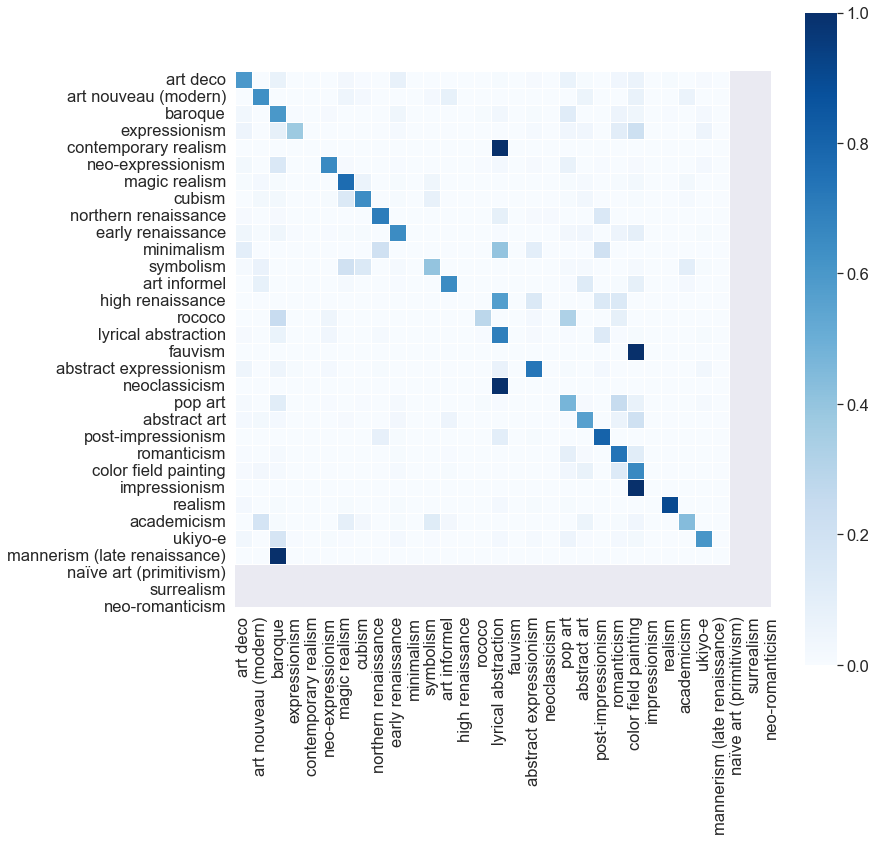

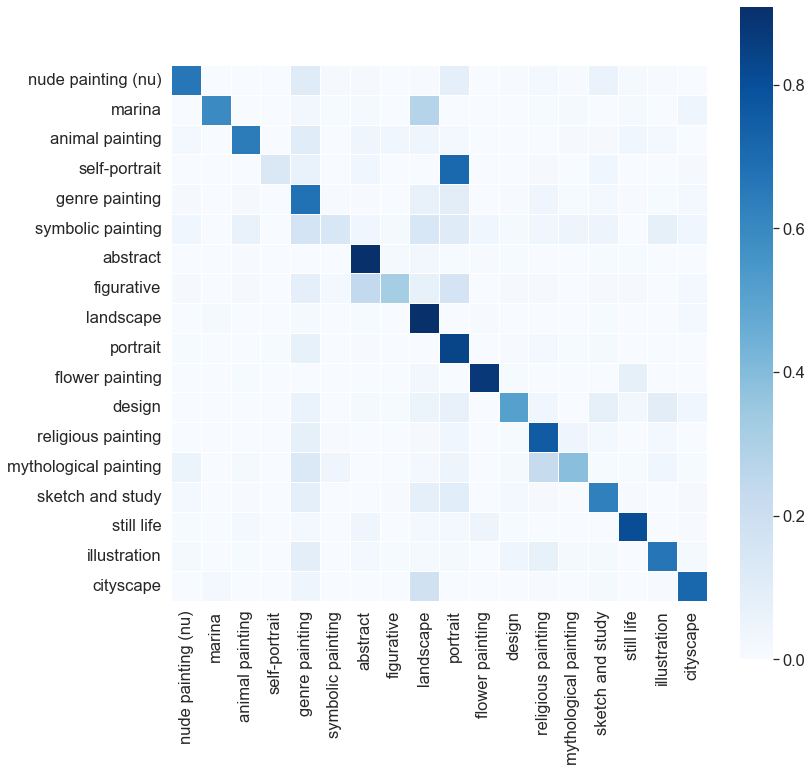

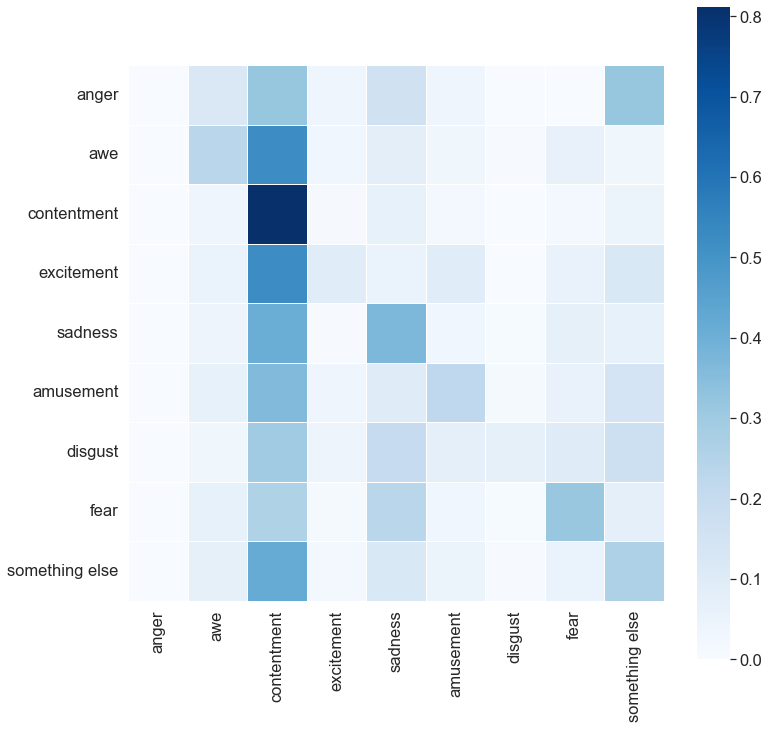

In [49]:
model = torch.load('best_new_multitask_model.pt').to('cuda:0') #cuda:0
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, drop_last = False)
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')#macro
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [50]:
results_df

,Top1,Top2,Macro-F1
style,0.633103,0.807969,0.475288
genre,0.752337,0.88567,0.634538
emotion,0.458544,0.643525,0.275452


In [30]:
results_df.to_csv('results_multi_task_fine_tuning.csv')

In [25]:
import torch
torch.cuda.empty_cache()

Nuovo test, senza encoder pre-trained

In [31]:
model = MultiTaskClassificationModel(data = train, hidden_channels = 128, head_num_layers = 5).to(device)
model

MultiTaskClassificationModel(
  (encoder): GraphModule(
    (convs): ModuleList(
      (0): ModuleDict(
        (artist__belongstofield__field): GATConv((-1, -1), 128, heads=1)
        (artist__belongstomovement__movement): GATConv((-1, -1), 128, heads=1)
        (artist__haspatron__people): GATConv((-1, -1), 128, heads=1)
        (artist__hassubject__subject): GATConv((-1, -1), 128, heads=1)
        (artist__relatedtoschool__training_node): GATConv((-1, -1), 128, heads=1)
        (artist__trainedby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__about__tag): GATConv((-1, -1), 128, heads=1)
        (artwork__createdby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__elicit__emotion): GATConv((-1, -1), 128, heads=1)
        (artwork__hasgenre__genre): GATConv((-1, -1), 128, heads=1)
        (artwork__hasperiod__period): GATConv((-1, -1), 128, heads=1)
        (artwork__hasstyle__style): GATConv((-1, -1), 128, heads=1)
        (artwork__locatedin__city): GATConv((-

In [32]:
torch.cuda.empty_cache()

In [33]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder(train.x_dict, train.edge_index_dict)

RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 2.00 GiB total capacity; 1.54 GiB already allocated; 0 bytes free; 1.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)

In [14]:
model = torch.load('best_multitask_model.pt').to('cuda:0')
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, drop_last = False)
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

  0%|          | 0/51 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

In [ ]:
results_df

In [ ]:
results_df.to_csv('resuls_multi_task_scratch.csv')